# 4. An example of a coupled adaptive speciation and landscape evolution model

We will use [Fastscape](https://fastscape.readthedocs.io/en/latest/)  to create a mountain environment to which organisms can adapt. 

## Import libraries

We first need to import the libraries and methods as we did before and add: our speciation model (IR12Speciation), methods to compute the relationship between the environmental field and a trait (ElevationEnvField, CompoundEnvironment, FastscapeElevationTrait), a method to assign the same random seed to different model components of the model (RandomSeedFederation) and some extra tools to work with the results:

In [1]:
from fastscape.models import basic_model
import numpy as np
import xsimlab as xs
import pandas as pd
%load_ext xsimlab.ipython
import matplotlib.pyplot as plt
from adascape.fastscape_ext import IR12Speciation, ElevationEnvField, FastscapeElevationTrait, CompoundEnvironment, RandomSeedFederation
import extra_tools as ext

## Inspect the model

Now lets update the basic model from fastscape with our adaptive speciation model without competition and visualize it:
```python
adascape_model = basic_model.update_processes({
    'life': IR12Speciation,
    'trait_elev':FastscapeElevationTrait,
    'life_env': CompoundEnvironment,
    'elevation':ElevationEnvField,
    'random': RandomSeedFederation
})

adascape_model.visualize()
```

One can also check each process added to the model, for example:
```python
adascape_model.life
```


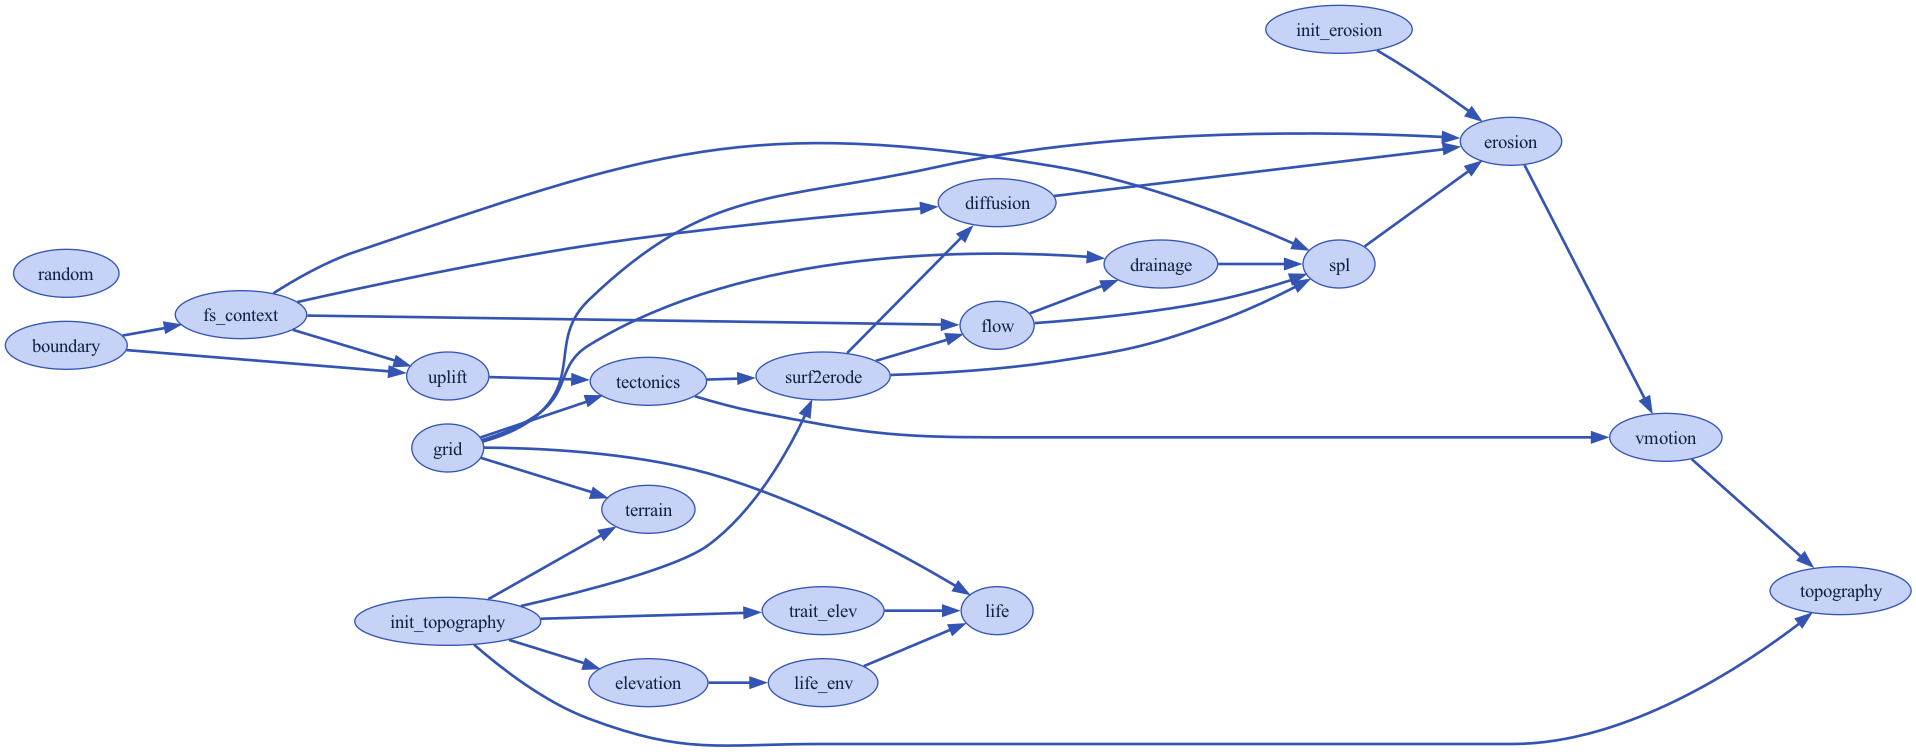

In [2]:
adascape_model = basic_model.update_processes({
    'life': IR12Speciation,
    'trait_elev':FastscapeElevationTrait,
    'life_env': CompoundEnvironment,
    'elevation':ElevationEnvField,
    'random': RandomSeedFederation
})

adascape_model.visualize()

In [3]:
adascape_model.life

<IR12Speciation 'life' (xsimlab process)>
Variables:
    trait               [out] ('trait',) names of the trait(s)
    init_trait_funcs     [in] <--- group 'init_trait_funcs'
    opt_trait_funcs      [in] <--- group 'opt_trait_funcs'
    init_abundance       [in] initial number of individuals
    random_seed          [in] random number generator seed
    taxon_threshold      [in] threshold value used in our taxon def...
    taxon_def            [in] Taxon definition based on common ance...
    init_x_range_min     [in] min range of individuals on x coordinate
    init_x_range_max     [in] max range of individuals on x coordinate
    init_y_range_min     [in] min range of individuals on y coordinate
    init_y_range_max     [in] max range of individuals on y coordinate
    rho                  [in] Correlation coefficient between trait...
    sigma_u              [in] trait-mediated competition for a limi...
    sigma_f              [in] environmental fitness selectivity or ...
    sig

## Create a model setup 

Similarly, we will use the create_setup command to build our model 
```python
%create_setup model_woc --default --verbose
```
We will use the same parametrization as before. We will **initialize a population** of 100 individuals all with the same **initial trait value** of 0.25 (i.e. equal initial min and max trait value). The trait-environment relationship is going to be described by a linear function with a **slope** of 0.95, where the min and maximum elevation can be set to 0 and 4500m. 

```python
input_vars={
    ...
    'life__init_abundance': 100,
    'trait_elev__init_trait_min': 0.25,
    'trait_elev__init_trait_max': 0.25,
    'trait_elev__lin_slope': 0.95,
    'trait_elev__norm_min': 0,
    'trait_elev__norm_max': 4500,
    ...
}
```

We will set **local carrying capacity** to 50 individuals in a  **neighbourhood radius** of 2e4 m. The **dispersal variability** or $\mathbf{\sigma_d}$ will be set to 5e3 m. The **mutation probability** to 0.005 with a **mutation variability** or $\mathbf{\sigma_m}$ of 0.05 in trait units and without **trait-mediated competition** $\mathbf{\sigma_u}$ will be greater or equat to 1. Last the **environmental fitness variability** or $\mathbf{\sigma_f}$ we will set to 0.3 in trait units  

```python
input_vars={
    ...
    'life__r': 2e4,
    'life__K': 50,
    'life__sigma_d': 1000.,
    'life__p_m': 0.005,
    'life__sigma_m': 0.05,
    'life__sigma_f': 0.3,
    'life__sigma_u': 1.0,
    ...
}
```
Last, we will retrieve the following variables:

```python
output_vars={'topography__elevation': 'out',
             'life__x': 'out',
             'life__y': 'out',
             'life__traits': 'out',
             'life__taxon_id': 'out',
             'life__ancestor_id': 'out'}
```

In [4]:
# %create_setup model_woc --default --verbose
the_clock = np.linspace(0, 10e6, 1001) 
rand_seed = 1234

ds_in = xs.create_setup(
    model=adascape_model,
    clocks = {'time': the_clock,
         'out': the_clock[::10]},
    master_clock='time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [101, 101],
        # total grid length in (y, x)
        'grid__length': [100e3, 100e3],
        # node status at borders
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        # uplift rate
        'uplift__rate': 1e-3,
        # bedrock channel incision coefficient
        'spl__k_coef': 1e-5,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # diffusivity (transport coefficient)
        'diffusion__diffusivity': 1e-2,
        # random seed
        'init_topography__seed': None,
        # initial number of individuals
        'life__init_abundance': 100,
        # random number generator seed
        'life__random_seed': rand_seed,
        # threshold value used in our taxon definition algorithm to split a group of
        # individuals into two taxon clusters
        'life__taxon_threshold': 0.035,
        # Taxon definition based on common ancestry and traits ('traits') or common ancestry,
        # traits and location ('traits_location')
        'life__taxon_def': 'traits',
        # min range of individuals on x coordinate
        'life__init_x_range_min': None,
        # max range of individuals on x coordinate
        'life__init_x_range_max': None,
        # min range of individuals on y coordinate
        'life__init_y_range_min': 0,
        # max range of individuals on y coordinate
        'life__init_y_range_max': 20e3,
        # Correlation coefficient between traits, 0 means that traits are independent, where a
        # value of rho different from 0 and between -1 and 1, will determine the degree of
        # correlation between traits for all individuals
        'life__rho': 0,
        # trait-mediated competition for a limiting resource, where the degree of trait
        # similarity is given by this parameter. If its value is =>1 all individuals in the
        # local neighbourhood are counted, but if its values is < 1 then only those
        # individuals with similar trait values are counted.
        'life__sigma_u': 1,
        # environmental fitness selectivity or width around optimal trait value for each
        # individual's trait
        'life__sigma_f': 0.3,
        # dispersal variability in meters
        'life__sigma_d': 5e3,
        # trait variability of mutated offspring
        'life__sigma_m': 0.05,
        # mutation probability
        'life__p_m': 0.005,
        # fixed neighborhood radius
        'life__r': 2e4,
        # carrying capacity within a neighborhood
        'life__K': 50,
        # min initial trait value
        'trait_elev__init_trait_min': 0.25,
        # max initial trait value
        'trait_elev__init_trait_max': 0.25,
        # slope of opt. trait vs. elevation linear relationship
        'trait_elev__lin_slope': 0.95,
        # min elevation value for normalization
        'trait_elev__norm_min': 0,
        # max elevation value for normalization
        'trait_elev__norm_max': 4500,
        # random number generator seed
        'random__seed': rand_seed,
    },
    output_vars={'topography__elevation': 'out',
                 'life__x': 'out',
                 'life__y': 'out',
                 'life__traits': 'out',
                 'life__taxon_id': 'out',
                 'life__ancestor_id': 'out'}
)

## Run the model

In [5]:
with adascape_model, xs.monitoring.ProgressBar():
    ds_out_woc = ds_in.xsimlab.run()

             0% | initialize 

## Visualize the solution of the speciation model without competition

First lets get the results in a format easier to manipulate like [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) using the build-in tool **ext.get_dataframe** provided here

In [6]:
dtf_woc=ext.get_dataframe(ds_out_woc) 
dtf_woc

,out,ind,taxon_id,ancestor_id,trait_elev,y,x
0,0.0,0,1.0,0.0,0.250000,5956.801812,97669.976670
1,0.0,1,1.0,0.0,0.250000,12383.220327,38019.573502
2,0.0,2,1.0,0.0,0.250000,6035.148592,92324.623376
3,0.0,3,1.0,0.0,0.250000,3496.929023,26169.242386
4,0.0,4,1.0,0.0,0.250000,9910.103904,31909.705841
...,...,...,...,...,...,...,...
65057,10000000.0,457,1763.0,1714.0,0.149502,1144.142018,62156.901180
65058,10000000.0,458,1763.0,1714.0,0.149502,2898.867638,65521.325382
65059,10000000.0,459,1763.0,1714.0,0.149502,6118.011990,57162.115617
65060,10000000.0,460,1763.0,1714.0,0.149502,1486.300133,51107.705405


Then we can plot for some selected time steps the topography and the distribution of taxa by using [pandas.DataFrame.groupby](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) and [pyplot.scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html).

Notice that on each time step, each taxon is depicted with a different marker and colour. 

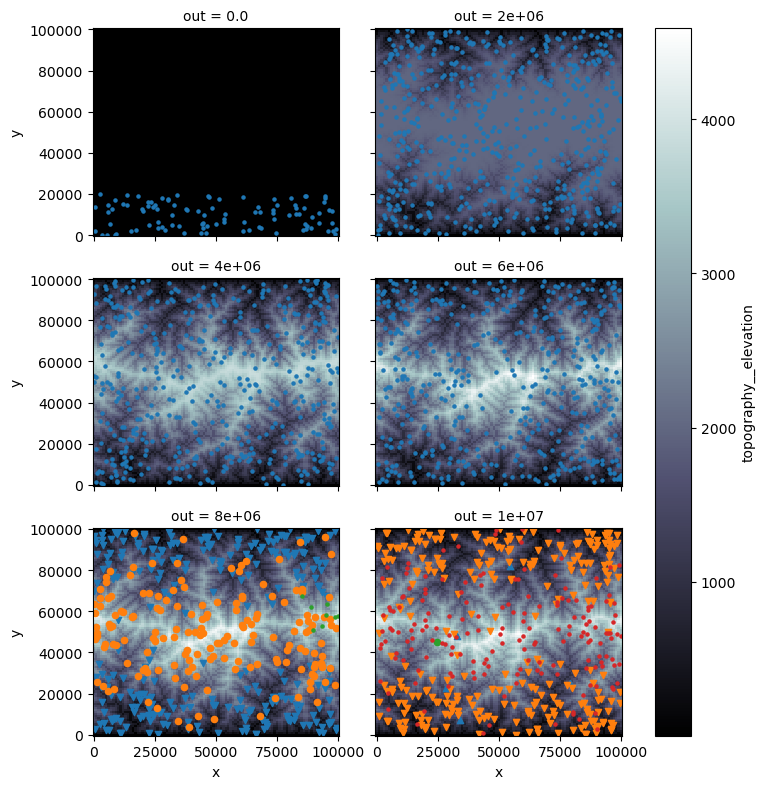

In [7]:
time_sel = np.arange(0, 11e6, 2e6)
ext.plot_topo_taxa(ds_out_woc, dtf_woc, time_sel)

The temporal dynamics for the number of individuals and taxon richness can be explored using a combination of [pandas operations](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#flexible-apply) and basic [pyplot routines](https://matplotlib.org/stable/tutorials/introductory/pyplot.html). The temporal and spatial distribution of the trait is shown with [two-dimensional histograms](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist2d.html), where the darker the colour the higher the number of individuals with a trait value at particular time or location along the Y axis.

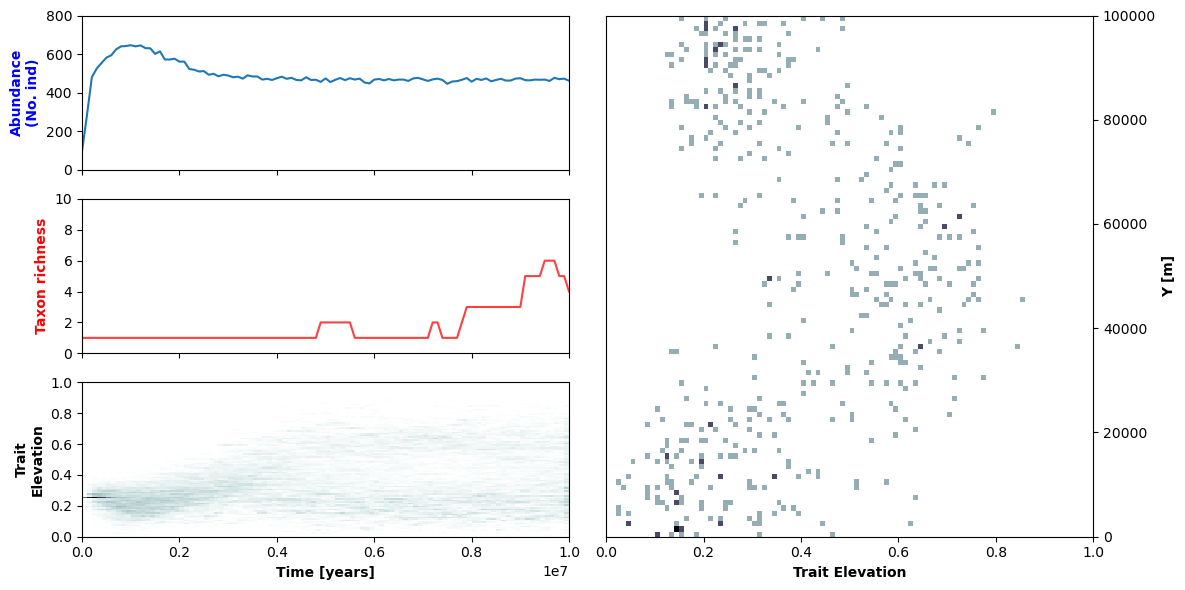

In [8]:
fig2, axs2 = plt.subplots(3, 2, sharex="col", figsize=(12, 6))
gs2 = axs2[1, 1].get_gridspec()
for ax2 in axs2[0:, 1:].flatten():
    ax2.remove()
ax2big = fig2.add_subplot(gs2[0:, -1])
axs2[0,0].plot(dtf_woc.groupby('out').size())
axs2[1,0].plot(dtf_woc.groupby(['out']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)
h,xedge,yedge,_=axs2[2,0].hist2d(x=dtf_woc['out'], y=dtf_woc['trait_elev'], 
                                 range=((0, 10e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=ax2big.hist2d(x=dtf_woc['trait_elev'].loc[dtf_woc['out']==max(dtf_woc['out'])], 
                             y=dtf_woc['y'].loc[dtf_woc['out']==max(dtf_woc['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
ax2big.yaxis.set_label_position("right")
ax2big.yaxis.tick_right()
ax2big.set_xlabel('Trait Elevation', weight='bold')
ax2big.set_ylabel('Y [m]', weight='bold')
axs2[0,0].set_ylabel('Abundance\n(No. ind)', weight='bold', color='blue')
axs2[0,0].set_ylim(0, 800)
axs2[1,0].set_ylabel('Taxon richness', weight='bold', color='red')
axs2[1,0].set_ylim(0, 10)
axs2[2,0].set_ylabel('Trait\nElevation', weight='bold')
axs2[2,0].set_xlabel('Time [years]', weight='bold')
fig2.tight_layout()

## The adaptive speciation model with competition

To run the adaptive speciation model with competition we just need to decrease $\mathbf{\sigma_u}$ to be less than 1:

In [9]:
with adascape_model, xs.monitoring.ProgressBar():
    ds_out_wic = ds_in.xsimlab.update_vars(input_vars={'life': {
            'sigma_u': 0.3,
    }
    }   
    ).xsimlab.run(check_dims='transpose')

             0% | initialize 

In [10]:
dtf_wic=ext.get_dataframe(ds_out_wic) 
dtf_wic

,out,ind,taxon_id,ancestor_id,trait_elev,y,x
0,0.0,0,1.0,0.0,0.250000,5956.801812,97669.976670
1,0.0,1,1.0,0.0,0.250000,12383.220327,38019.573502
2,0.0,2,1.0,0.0,0.250000,6035.148592,92324.623376
3,0.0,3,1.0,0.0,0.250000,3496.929023,26169.242386
4,0.0,4,1.0,0.0,0.250000,9910.103904,31909.705841
...,...,...,...,...,...,...,...
71205,10000000.0,605,6138.0,6006.0,0.089094,2593.266930,39596.807542
71206,10000000.0,606,6138.0,6006.0,0.067481,4321.325189,19674.732385
71207,10000000.0,607,6138.0,6006.0,0.131690,23329.026669,65139.875486
71208,10000000.0,608,6138.0,6006.0,0.172674,27570.126487,19657.224119


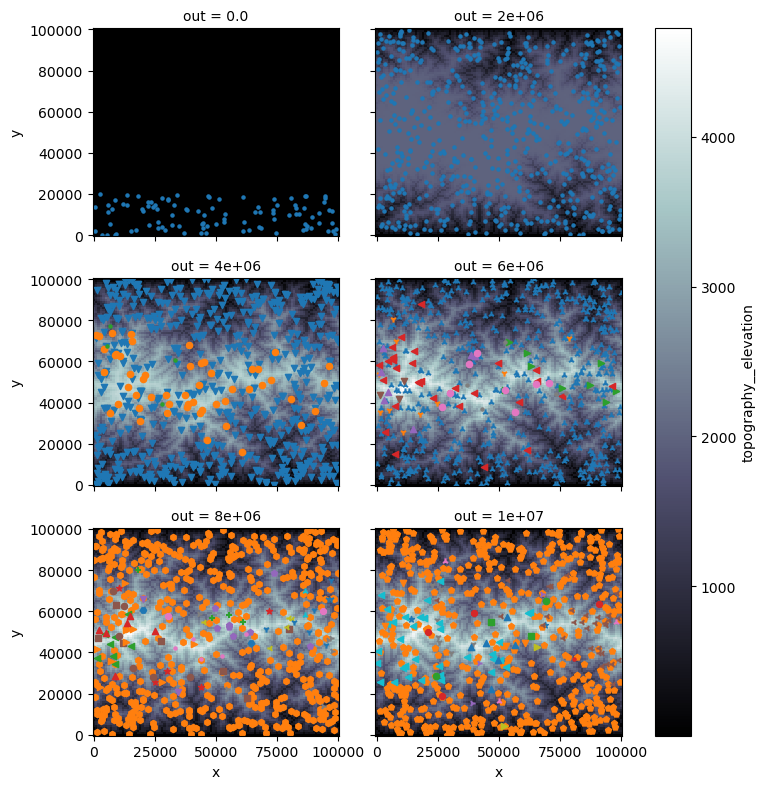

In [11]:
ext.plot_topo_taxa(ds_out_wic, dtf_wic, time_sel)

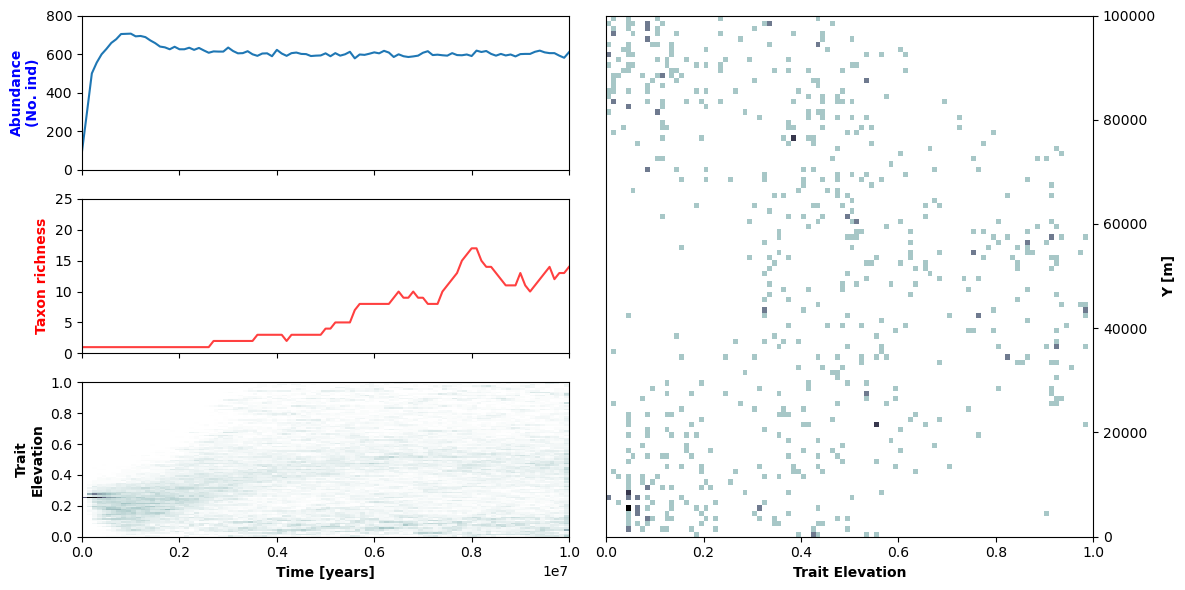

In [12]:
fig4, axs4 = plt.subplots(3, 2, sharex="col", figsize=(12, 6))
gs4 = axs4[1, 1].get_gridspec()
for ax4 in axs4[0:, 1:].flatten():
    ax4.remove()
ax4big = fig4.add_subplot(gs2[0:, -1])
axs4[0,0].plot(dtf_wic.groupby('out').size())
axs4[1,0].plot(dtf_wic.groupby(['out']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)
h,xedge,yedge,_=axs4[2,0].hist2d(x=dtf_wic['out'], y=dtf_wic['trait_elev'], 
                                 range=((0, 10e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=ax4big.hist2d(x=dtf_wic['trait_elev'].loc[dtf_wic['out']==max(dtf_wic['out'])], 
                             y=dtf_wic['y'].loc[dtf_wic['out']==max(dtf_wic['out'])], 
                                 range=((0, 1), (0, 1e5)), 
                                 bins=(100, 100), cmap='bone_r')
ax4big.yaxis.set_label_position("right")
ax4big.yaxis.tick_right()
ax4big.set_xlabel('Trait Elevation', weight='bold')
ax4big.set_ylabel('Y [m]', weight='bold')
axs4[0,0].set_ylabel('Abundance\n(No. ind)', weight='bold', color='blue')
axs4[0,0].set_ylim(0,800)
axs4[1,0].set_ylabel('Taxon richness', weight='bold', color='red')
axs4[1,0].set_ylim(0, 25)
axs4[2,0].set_ylabel('Trait\nElevation', weight='bold')
axs4[2,0].set_xlabel('Time [years]', weight='bold')
fig4.tight_layout()

Now, lets compare the predicted patterns of biodiversity along an elevational gradient at selected time steps. For this we can calculate the [hypsometric curve](https://en.wikipedia.org/wiki/Hypsometry), which show the proportion of land area at a particular elevation. Then we can compute the number of taxon, or **taxon richness**, at those elevational bins. Later we can fit a non-linear regression to better compare the areas at a given elevation and find out where the peak of diversity occurs. 

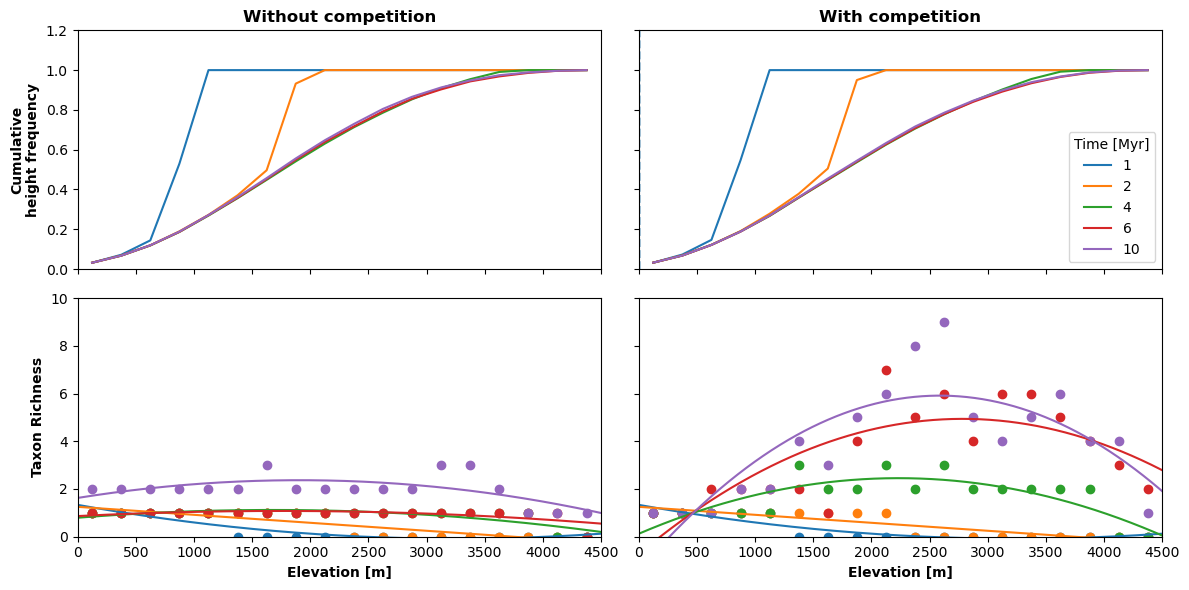

In [13]:
fig5, ax5 = plt.subplots(2, 2,  sharey="row", sharex="col", figsize=(12, 6))
H_i = []
for t in [1e6, 2e6, 4e6, 6e6, 10e6]:
    for c, exp in enumerate(['woc', 'wic']):
        if exp=='woc':
            ds_tsel = ds_out_woc.sel(out=t)
            ax5[0,c].set_title('Without competition', weight='bold')
        elif exp=='wic':
            ds_tsel = ds_out_wic.sel(out=t)
            ax5[0,c].set_title('With competition', weight='bold')

        counts, bins = np.histogram(ds_tsel.topography__elevation, np.arange(0, 4501, 250))
        bins_mean_ele = (bins[:-1] + bins[1:])/2.0
    
        ax5[0,c].plot(bins_mean_ele, counts.cumsum()/counts.cumsum().max())
        
        H_i = np.append(H_i, ((ds_tsel.topography__elevation.mean() - ds_tsel.topography__elevation.min()) / 
               (ds_tsel.topography__elevation.max() - ds_tsel.topography__elevation.min()) )
                        )
              
        elevation_i = (ds_tsel.topography__elevation.sel(x=ds_tsel.life__x.dropna('ind'), y=ds_tsel.life__y.dropna('ind'), method='nearest') )
        dtf_ele_i = (pd.DataFrame({'elevation_i':elevation_i, 'taxon_id':ds_tsel.life__taxon_id.dropna('ind'), 'ele_groups':pd.cut(elevation_i, bins=bins)} ))
        ax5[1,c].scatter(bins_mean_ele, dtf_ele_i.groupby('ele_groups').nunique().taxon_id, clip_on='False')
        
        fit = ext.fit_nlsq(bins_mean_ele, dtf_ele_i.groupby('ele_groups').nunique().taxon_id.values, 0, 4500, 'elevation')
        ax5[1,c].plot(fit.elevation, fit.taxon_richness)
        
ax5[0,c].vlines(x=H_i, ymin=0, ymax=1.2, linestyles='dashed')
ax5[0,0].set_xlim(0, 4500)
ax5[0,1].set_xlim(0, 4500)
ax5[0,0].set_ylim(0, 1.2)
ax5[1,0].set_ylim(0, 10)
ax5[0,1].legend(['1', '2', '4', '6', '10'], loc='lower right', title='Time [Myr]')
ax5[0,0].set_ylabel('Cumulative\nheight frequency', weight='bold')
ax5[1,0].set_ylabel('Taxon Richness', weight='bold')
ax5[1,0].set_xlabel('Elevation [m]', weight='bold')
ax5[1,1].set_xlabel('Elevation [m]', weight='bold')
fig5.tight_layout()